# Velib availability
## Mercredi 14 Aout - Geoffroy Leboucher

### Objectif
L'objectif est de de prédire à un instant donné la liste des stations Vlib dans le 2eme arrondissement avec au moins une place libre (champ *available_stands* > 0). Pour cela on dispose de 3 type de base de données : 
**Colonnes** :
* La météo/heure. Données utiles : Température, Pluie
* La géolocalisation des stations. Données utiles : Longitude, latitude?
* Un historique des places disponibles/5mins. Données utiles  : l'heure, la date, nbr de places totales, nbr de places libres.

### Obtenir les données
Dans un permier temps, il est bien entendu nécessaire de se procurer les donner et les stocker sous forme de Dataframe. 

In [1]:
import random as rd
import datetime as dt
from os import listdir
import time as tm
import numpy as np
import pandas as pd

rd.seed(21)

In [11]:
meteo = pd.read_csv('data/weather_paris.csv')
# print(meteo.head())
print(meteo.shape)
print(meteo.columns)

stations = pd.read_csv('data/velib_stations_infos.csv')
# print(stations.head())
print(stations.shape)
print(stations.columns)

history = None
for file in listdir("data"):
    if file.startswith("releves_75002_2015") and file.endswith(".csv"):
        history = pd.concat([history, pd.read_csv("data/" + file)]) #, header=None
print(history.shape)
print(history.columns)

(764, 33)
Index(['a_date_utc', 'a_searched_location_city', 'a_searched_location_country',
       'a_time', 'a_time_utc', 'dewpti_avg', 'dewptm_avg', 'fog_avg',
       'hail_avg', 'heatindexi_avg', 'heatindexm_avg', 'hum_avg',
       'precipi_avg', 'precipm_avg', 'pressurei_avg', 'pressurem_avg',
       'rain_avg', 'snow_avg', 'tempi_avg', 'tempm_avg', 'thunder_avg',
       'tornado_avg', 'visi_avg', 'vism_avg', 'wdird_avg', 'wdire_min',
       'wdire_max', 'wgusti_avg', 'wgustm_avg', 'windchilli_avg',
       'windchillm_avg', 'wspdi_avg', 'wspdm_avg'],
      dtype='object')
(1228, 6)
Index(['number', 'name', 'address', 'latitude', 'longitude', 'geopoint'], dtype='object')
(1727400, 7)
Index(['station_id', 'stands', 'available_stands', 'available_bikes', 'status',
       'date_record', 'day_of_record'],
      dtype='object')


### Nettoyer les données
Il faut ensuite faire le menage dans ces données : 
* Remettre en orde les colonnes et choisir des index appropriés. Supprimer les colonnes que l'on ne souhaite pas.
* Gerer les valeurs manquantes et les anomalies, soit en les supprimant soit en les modifiant.
* Créer une base de donnée unique

In [241]:
##Format
#Il y a un bon nombre de duplicates dans history
history = history.drop_duplicates()

#Ne conserver que les colonnes utiles (les autres ne presentnt soit pas d'interet soit pas de variation)
meteo=meteo.drop(['a_searched_location_city', 'a_searched_location_country',
        'a_time_utc', 'dewpti_avg', 'dewptm_avg', 'fog_avg',
       'hail_avg', 'heatindexi_avg', 'heatindexm_avg', 'hum_avg',
       'precipi_avg', 'precipm_avg', 'pressurei_avg', 'pressurem_avg',
        'snow_avg', 'tempi_avg',  'thunder_avg',
       'tornado_avg', 'visi_avg','vism_avg', 'wdird_avg', 'wdire_min',
       'wdire_max', 'wgusti_avg', 'wgustm_avg', 'windchilli_avg',
       'windchillm_avg', 'wspdi_avg', 'wspdm_avg'], axis=1)
stations=stations.drop([ 'name', 'address', 'geopoint'], axis=1)

history=history.drop(['available_bikes', 'status'], axis=1)


In [242]:
#NaNs
print(history.isna().sum())
print(meteo.isna().sum())
print(stations.isna().sum())

#Pas de NaN du coup pas de soucis à se faire

station_id          0
stands              0
available_stands    0
date_record         0
day_of_record       0
dtype: int64
a_date_utc    0
a_time        0
rain_avg      0
tempm_avg     0
dtype: int64
number       0
latitude     0
longitude    0
dtype: int64


In [243]:
#Anomalie
print(history.describe())
print(meteo.describe())
print(stations.describe())

#Les valeurs ne semblent pas aberrantes, pas besoin d'éliminer/traiter les anomalies

         station_id        stands  available_stands
count  69096.000000  69096.000000      69096.000000
mean    2026.416667     29.625000         14.563868
std       35.402606     10.455587         12.961813
min     2001.000000     15.000000          0.000000
25%     2006.750000     20.750000          4.000000
50%     2012.500000     29.500000         12.000000
75%     2020.250000     36.250000         22.000000
max     2108.000000     59.000000         59.000000
           a_time    rain_avg   tempm_avg
count  764.000000  764.000000  764.000000
mean    11.574607    0.067408    9.106675
std      6.855439    0.233999    2.994109
min      0.000000    0.000000    1.000000
25%      6.000000    0.000000    7.000000
50%     12.000000    0.000000   10.000000
75%     17.000000    0.000000   11.000000
max     23.000000    1.000000   16.000000
             number     latitude    longitude
count   1228.000000  1228.000000  1228.000000
mean   15693.242671    48.859448     2.343504
std     9245.810

In [244]:
#Traiter les dates en une colonne
history['Datetime']=pd.to_datetime(history['date_record'])
history['Hour']=history['Datetime'].apply(lambda d: dt.datetime(d.year, d.month, d.day, d.hour,0))
# print(history['Hour'])
meteo['Hour']=pd.to_datetime(meteo['a_date_utc']) + pd.to_timedelta(meteo['a_time'], unit='h')

# meteo=meteo.set_index('Datetime') 
# meteo=meteo.index.to_period("H")

# print(meteo['Hour'])

In [245]:
#Merge
Hist = pd.merge(history,stations,how="inner",left_on='station_id', right_on='number')
Hist = pd.merge(Hist,meteo,how="inner",left_on='Hour', right_on='Hour')
Hist=Hist.drop(['day_of_record','a_date_utc', 'number'], axis=1)
# Hist.head()

In [246]:
#Création d'une colonne indiquant si la station a des places libres
Hist['Free']=Hist['available_stands']==0
Hist['Free']=Hist['Free'].replace({True:'0',False:'1'}).astype(int)
# print(Hist['Free'])

#Création d'une colonne indiquant le jour de la semaine
Hist['WeekD'] = Hist['Datetime'].dt.dayofweek
# print(Hist['WeekD'])

#Création d'une colonne indiquant si week-end
Hist['IsWn'] = Hist['WeekD']>=5
Hist['IsWn']=Hist['IsWn'].replace({True:'1',False:'0'}).astype(int)
# print(Hist['IsWn'])


### Feature Engineering
Une fois les données rangées correctement, on peut alors commencer à les analyser afin de discerner des tendances. Cette étape peut se découper en plusieurs taches :
* Visualisation des données
* L'étude des données statistiques classiques
* Recherche d'éventuelles correlations entre les parametres

/!\ à decouper les données en classes,
Merges,
pivot table,
Sort,
Group by,
Apply,
T_test,
ChartS,
PairPlot,
%répartition
...

Les stations sont en moyenne pleinne 11.889696855227122% du temps


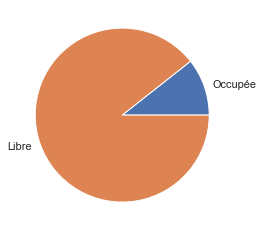

In [247]:
#Data Visu
import matplotlib
import matplotlib.pyplot as plt
pieFree= pd.DataFrame([(Hist['Free']==0).sum(), (Hist['Free']==1).sum()], index=[ 'Occupée','Libre'])
plt.pie(pieFree[0], labels=pieFree.index);
print("Les stations sont en moyenne pleinne " + str((Hist['Free']==0).sum()/ (Hist['Free']==1).sum()*100) +'% du temps')

Text(0, 0.5, 'y label')

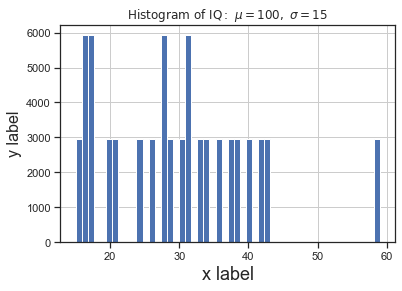

In [248]:
#Repartition du nombre de place par station
plt.hist(Hist["stands"], bins=50, label = 'TEST') #normed=X pour avoir somme  = X
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0,800])
plt.grid(True)
plt.xlabel('x label', fontsize=18)
plt.ylabel('y label', fontsize=16)

In [249]:
#Nombre de station:
print('Il y a au total ',Hist["station_id"].nunique(),'stations dans le 2eme arr. de Paris')

Il y a au total  24 stations dans le 2eme arr. de Paris


In [250]:
#Données Stat classiques
Hist.describe()
# Hist.columns

,station_id,stands,available_stands,latitude,longitude,a_time,rain_avg,tempm_avg,Free,WeekD,IsWn
count,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000,71088.000000
mean,2026.416667,29.625000,14.196151,48.868225,2.342684,11.548953,0.040513,8.486158,0.893737,3.311276,0.299797
std,35.402599,10.455584,12.912060,0.002049,0.005648,6.856870,0.175413,3.765561,0.308176,1.799086,0.458172
min,2001.000000,15.000000,0.000000,48.864582,2.332515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2006.750000,20.750000,3.000000,48.866767,2.338240,6.000000,0.000000,5.000000,1.000000,2.000000,0.000000
50%,2012.500000,29.500000,11.000000,48.868095,2.342542,11.000000,0.000000,9.000000,1.000000,4.000000,0.000000
75%,2020.250000,36.250000,22.000000,48.870079,2.346870,17.000000,0.000000,11.000000,1.000000,5.000000,1.000000
max,2108.000000,59.000000,59.000000,48.871446,2.351670,23.000000,1.000000,16.000000,1.000000,6.000000,1.000000


C:\Users\geoff\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\geoff\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


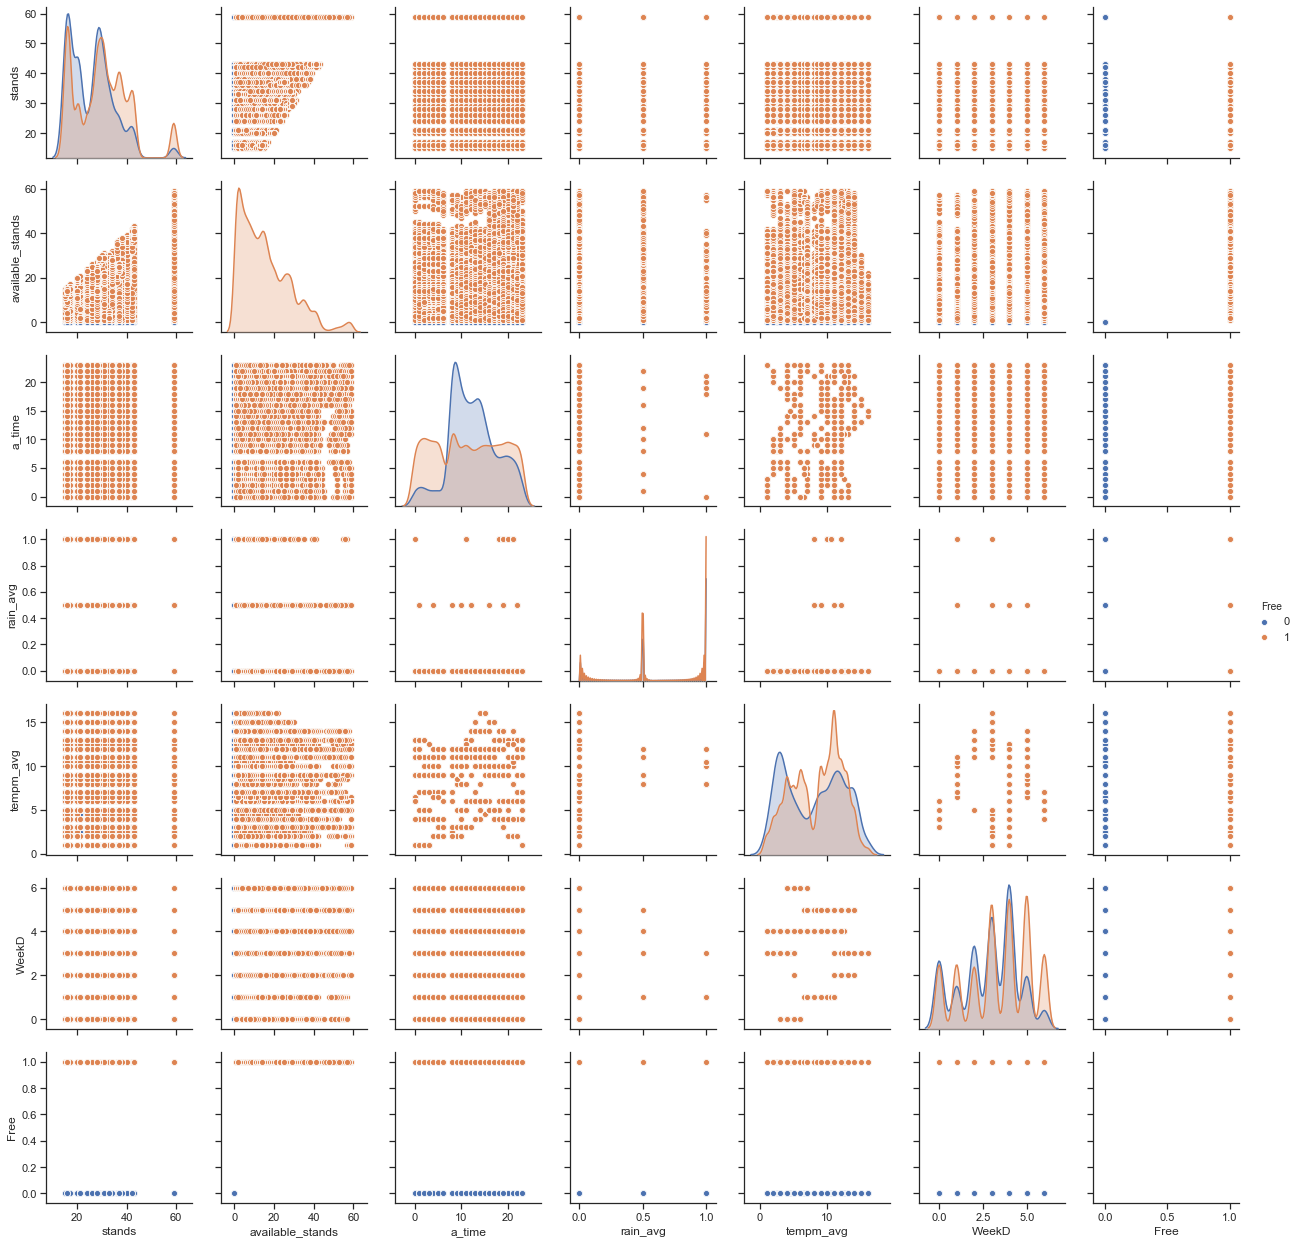

In [251]:
#Correlation
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(Hist[['stands', 'available_stands','a_time', 'rain_avg', 'tempm_avg','WeekD', 'Free']],hue='Free')

#Il n'y a pas de tendance qui se détache du lot.

    size  avg temp  avg rain   avg hour  avg in Wn
1  63534  8.540805  0.041993  11.436081   0.319262
0   7554  8.026542  0.028065  12.498279   0.136087


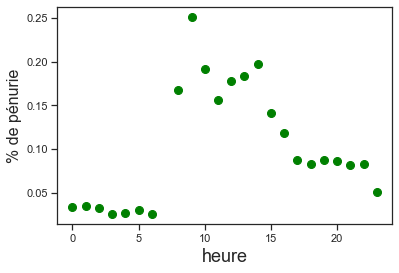

In [252]:
#group By
#Free:
Free =  pd.DataFrame(index=Hist['Free'].unique(), columns=['size', 'avg temp', 'avg rain',  'avg hour','avg in Wn'])
Free['size'] = Hist.groupby('Free').size()
Free['avg temp']= Hist.groupby('Free').agg({'tempm_avg': np.average})
Free['avg rain']  = Hist.groupby('Free').agg({'rain_avg': np.average})
Free['avg hour'] = Hist.groupby('Free').agg({'a_time': np.average})#Probleme de cyclicité
Free['avg in Wn'] = Hist.groupby('Free').agg({'IsWn': np.average})
print(Free)
#CONCLUSIONS: On constate de nette differences entre certains parametres

#heure
Heure = pd.DataFrame(index=Hist['a_time'].unique(), columns=['size','nb_Empty','%empty'])
Heure['size']=Hist.groupby('a_time').size()
Heure['nb_Empty']= Hist.groupby('a_time').agg({'Free': np.sum})
Heure['%empty']=1-Heure['nb_Empty']/Heure['size']

plt.plot(Heure.index,Heure['%empty'], color='green', marker='o',linewidth=0, markersize=8)
# plt.title('Titre')
plt.xlabel('heure', fontsize=18)
plt.ylabel('% de pénurie', fontsize=16);
# print(Heure.head())

In [253]:
#T_test
#Ce test permet de determiner s'il est judicieux d'utiliser 
#certaines des données qui nous sont fournies. Nous pourrions 
#alors savoir  si les reslutats sont exploitable/fiables ou non.
#Toutefois, pour trancher il faut détérminer une valeur seuil. 
#Or je n'ai pas assez de recul sur le domaine et les mesures pour choisir

### Préparation des données
Afin de pouvoir passer à la modélisation, il est nécessaire de préparer l'ensemble des données. Le but est de les rendre compréhensibles par l'algorithme de Machine Learning. Pour cela il faut : 
* Distinguer les parametres(Features) des cibles(Labels)
* Decouper notre base de donnée en deux : une partie pour entrainer l'algorithme, une pour le tester

In [254]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

In [255]:
#Features/Labels
print(Hist.columns)
print(Hist.head())
Features = ['stands', 'latitude', 'longitude','a_time', 'rain_avg', 'tempm_avg', 'WeekD','IsWn']
Labels=Hist['Free']


Index(['station_id', 'stands', 'available_stands', 'date_record', 'Datetime',
       'Hour', 'latitude', 'longitude', 'a_time', 'rain_avg', 'tempm_avg',
       'Free', 'WeekD', 'IsWn'],
      dtype='object')
   station_id  stands  available_stands               date_record  \
0        2005      15                 3  2015-12-09T23:00:03.000Z   
1        2005      15                 4  2015-12-09T23:05:02.000Z   
2        2005      15                 4  2015-12-09T23:10:03.000Z   
3        2005      15                 5  2015-12-09T23:15:02.000Z   
4        2005      15                 6  2015-12-09T23:20:02.000Z   

                   Datetime                Hour   latitude  longitude  a_time  \
0 2015-12-09 23:00:03+00:00 2015-12-09 23:00:00  48.865022   2.345068      23   
1 2015-12-09 23:05:02+00:00 2015-12-09 23:00:00  48.865022   2.345068      23   
2 2015-12-09 23:10:03+00:00 2015-12-09 23:00:00  48.865022   2.345068      23   
3 2015-12-09 23:15:02+00:00 2015-12-09 23:00:00  48.8

In [256]:
#Split Train/Test 
np.random.seed(21)
Hist['is_train'] = np.random.uniform(0, 1, len(Hist)) <= .8 
train, test = Hist[Hist['is_train']==True], Hist[Hist['is_train']==False] 
print("Shapes Train/tes",train.shape,test.shape)
print("Rapport non Free/tot",1-train['Free'].sum()/len(train))

Shapes Train/tes (56780, 15) (14308, 15)
Rapport non Free/tot 0.10693906305036982


In [257]:
#Pas d'encoding de catégories nécessaire 

In [258]:
#Cyclical data...

### Entrainement du modèle
Pour des raisons de simplicité et d'efficacité au vu du temps qu'il m'est imparti, j'ai décider de faire tourner un algorithme de Forêt d'arbres décisionnels à l'aide de Scikit.learn.

Avant de commencer nous avont besoin de nous fixer un objectif afin de vérifier que notre modèle à amélioré la situation. Actuellement on a vu qu'en moyenne 12% des stations sont vides. Il faut donc que notre modèle trouve la bonne réponse **plus souvent que 12% du temps.**

In [259]:
#Random Forest
clf = RandomForestClassifier(n_jobs=2, random_state=21,n_estimators =100) 
time0=dt.datetime.now()
clf.fit(train[Features], train['Free'])

# Timing
print('execution',dt.datetime.now()-time0)


execution 0:00:01.751324


### Résultats
Maintenant que le modèle est entrainé, nous allons pouvoir analyser ses performances.

In [260]:
#Prediction
preds = clf.predict(test[Features])
print(preds)

[1 1 1 ... 1 1 1]


In [261]:
#Score/Precision
print((test['Free']==preds).sum()/len(preds)*100,'% de bonnes réponses')
# print(len(preds),sum(preds))

#SCORE
print(clf.score(train[Features],  train['Free']))
print(clf.score(test[Features],  test['Free']))

93.54906346100084 % de bonnes réponses
0.9467241986615005
0.9354906346100084


In [262]:
#Confusion Matrix
pd.crosstab( test['Free'], preds, rownames=['Réalité'], colnames=['Prédiction'])#VISU RESULTS

Prédiction,0,1
Réalité,,
0,984,498
1,425,12401


In [263]:
#Extraction d'un arbre
from sklearn.tree import export_graphviz
import pydot
clf_tree = clf.estimators_[21]
export_graphviz(clf_tree, out_file = 'tree.dot', feature_names = Features, rounded = True, precision = 1)

#on constate que 'a_time' majoritaire => Verificaion :

In [264]:
#Feature Importance
print(list(zip(train[Features], clf.feature_importances_)))#Feature Importance

#Certain Features sont prédominants
#On peut se débarasser de ceux ayant une faible influence.

[('stands', 0.1000237516730941), ('latitude', 0.09804470284306634), ('longitude', 0.11892219057050392), ('a_time', 0.35097872690368964), ('rain_avg', 0.008750320949573474), ('tempm_avg', 0.1910295272777846), ('WeekD', 0.11646399307574279), ('IsWn', 0.015786786706545073)]


###### Regard Critique
On a dépassé de loins no objectifs, mais il existe peut etre d'autre moyens d'aller encore plus loin.\

### Améliorations
Cet premier jet de modèle est bien entendu perfectible. Etant nouveau dans ce domaine, je ne connais pas encore l'ensemble des méthodes d'amélioration du modèle. Toutefois, je connais quelques pistes d'amélioration.

In [265]:
#On peut se débarasser des Features ayant une faible influence.
#En effet on a vu que ces parametres n'ont pas d'influence sur
#le résultat. S'en débarasser permettra donc à notre algorithme 
#à gagner en rapidité
Features= ['stands', 'latitude', 'longitude','a_time', 'rain_avg', 'tempm_avg', 'WeekD']

#Training
clf = RandomForestClassifier(n_jobs=2, random_state=21,n_estimators =100) 
time0=dt.datetime.now()
clf.fit(train[Features], train['Free'])
# Timing
print('execution',dt.datetime.now()-time0)
#Results
print(clf.score(test[Features],  test['Free']))

execution 0:00:01.974015
0.9354906346100084


In [266]:
#Changer le rapport Free/tot car une catégorie est prédominante =>50/50
np.random.seed(21)
Hist['Equilibrage']=(Hist['Free']==0) | (np.random.uniform(0, 1, len(Hist)) <= .1)
train = Hist[Hist['Equilibrage']==True]
print("Shapes Train/tes",train.shape,test.shape)
print("Rapport non Free/tot",1-train['Free'].sum()/len(train))

#Training
clf = RandomForestClassifier(n_jobs=2, random_state=21,n_estimators =100) 
clf.fit(train[Features], train['Free'])
#Results
print(clf.score(test[Features],  test['Free']))

Shapes Train/tes (14014, 16) (14308, 15)
Rapport non Free/tot 0.5390323961752533
0.886986301369863


Si 50/50 = score de 88% (Très faible score en 0->1 mais fort en 1->0) (Préférable)\
Si pas 50/50 => score de 93%(moins d'erreur en 1->0 mais plus en 0->1)

Afin de permettre au modèle de disposer de plus de données,il est possible de le ré-entrainer avec les données qui n'ont pas été utilisées.


In [267]:
#New 50/50
for i in range(10):
    Hist['Equilibrage']=(Hist['Free']==0) | (np.random.uniform(0, 1, len(Hist)) <= .1)
    train = Hist[Hist['Equilibrage']==True]
#     print("Shapes Train/tes",train.shape,test.shape)
#     print("Rapport non Free/tot",1-train['Free'].sum()/len(train))

    # Training
    clf.fit(train[Features], train['Free'])
    
    #Results
    print(clf.score(test[Features],  test['Free']))


0.8847497903270898
0.8872658652502097
0.8857282639083031
0.888663684651943
0.886986301369863
0.8912496505451496
0.8823036063740565
0.8871260833100364
0.8862873916689964
0.8873357562202964


In [268]:
#Cross Validation afin d'éviter l'overfitting
#Consiste à redécouper la table Train en N puis entrainer 
#l'algorithme successivement (N fois) sur des permutations
# de ces tables (N-1 servent de Train et 1 de Scoring)
np.random.seed(21)
from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, train[Features], train['Free'], cv=5))
# print(clf.score(test[Features],  test['Free']))

[0.64331897 0.36242816 0.63959756 0.58569889 0.47879224]


In [271]:
#utiliser des sin/cos pour les données cycliques afin d'éviter 
#d'avoir une hiérarchisation fausse 

Hist['hr_sin'] = np.sin(Hist['a_time']*(2.*np.pi/24))
Hist['hr_cos'] = np.cos(Hist['a_time']*(2.*np.pi/24))
# Hist.head()

Features= ['stands', 'latitude', 'longitude','hr_sin','hr_cos', 'rain_avg', 'tempm_avg', 'WeekD']
Hist['is_train'] = np.random.uniform(0, 1, len(Hist)) <= .8 
train, test = Hist[Hist['is_train']==True], Hist[Hist['is_train']==False] 

#Training
clf = RandomForestClassifier(n_jobs=2, random_state=21,n_estimators =100) 
clf.fit(train[Features], train['Free'])
#Results
print(clf.score(test[Features],  test['Free']))
#Confusion Matrix
pd.crosstab( test['Free'], clf.predict(test[Features]), rownames=['Réalité'], colnames=['Prédiction'])


print(list(zip(train[Features], clf.feature_importances_)))#Feature Importance

0.933737487663894
[('stands', 0.10987511523244939), ('latitude', 0.10766613102397639), ('longitude', 0.13006214395598611), ('hr_sin', 0.1334286555209376), ('hr_cos', 0.1523954874592828), ('rain_avg', 0.009385696010281547), ('tempm_avg', 0.1929126730085684), ('WeekD', 0.16427409778851773)]


In [270]:
#Utiliser des algorithmes de Machine Learning plus performants

## Conclusion
Au cours de cette étude, j'ai tout d'abord récupéré les données, puis les ai nettoyé avant de les analyser. Après cela je me suis penché sur l'élaboration d'un modèle de Forêt d'arbres décisionnels.\

Notre objectif initial était de dépasser 12% de précision. Nous avons alors obtenu des résultats allant jusqu'à 93% de précision. Nous avons ensuite tenté d'appliquer des méthodes d'amélioration mais sans grand succes.